In [1]:
!pip install tensorflow boto3 scikit-learn pandas matplotlib seaborn

In [2]:
!pip install ultralytics

In [3]:
!pip install boto3 tensorflow scikit-learn matplotlib seaborn tqdm torch torchvision

In [4]:
!pip install boto3 tensorflow scikit-learn matplotlib pillow tqdm seaborn

In [5]:
!pip uninstall opencv-python-headless opencv-python -y
!pip install opencv-python-headless


Found existing installation: opencv-python-headless 4.11.0.86
Uninstalling opencv-python-headless-4.11.0.86:
  Successfully uninstalled opencv-python-headless-4.11.0.86
Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)


In [6]:
!pip install imbalanced-learn

In [7]:
!pip install tensorflow-addons

  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


#Code Version3

In [8]:
import os
import boto3
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from PIL import Image
from tqdm import tqdm

# Enhanced Configuration
bucket_name = "sagemaker-studio-010526272250-hsf94lgtf6i"
dataset_prefix = "Dentex_Challenge_Project_Image_Dataset/Ground_Truth"
disease_classes = ['BDC-BDR', 'Caries', 'Fractured-Teeth', 'Healthy-Teeth', 'Impacted-Teeth', 'Infection']
img_height = 384
img_width = 384
batch_size = 16
epochs = 100
initial_learning_rate = 3e-4
test_size = 0.15
validation_size = 0.15
seed = 42
local_dataset_dir = 'local_dataset'
dropout_rate = 0.3

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('dental_classification.log'),
        logging.StreamHandler()
    ]
)

def get_image_paths_and_labels_from_s3(bucket_name, dataset_prefix):
    """Fetch image paths and labels from S3."""
    logging.info(f"Fetching image paths and labels from S3 (dataset: {dataset_prefix})...")
    try:
        s3 = boto3.client('s3')
        image_paths = []
        labels = []
        
        paginator = s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=dataset_prefix)
        
        for page in pages:
            for obj in page.get('Contents', []):
                if obj['Key'].lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_key = obj['Key']
                    label_str = image_key.split('/')[-1].split('_')[0]
                    label_list = [label.strip() for label in label_str.split(',') if label.strip() in disease_classes]
                    
                    if label_list:
                        image_paths.append(image_key)
                        labels.append(label_list)

        if not image_paths:
            raise ValueError(f"No valid images found in S3 bucket at: {dataset_prefix}")
        logging.info(f"Found {len(image_paths)} images in S3 bucket.")
        
        return image_paths, labels
    except Exception as e:
        logging.error(f"Error fetching from S3: {e}")
        raise

def process_image(image_path):
    """Process image with enhanced preprocessing."""
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            img = img.resize((img_height, img_width), Image.Resampling.LANCZOS)
            img_array = np.array(img, dtype=np.float32)
            
            # Enhanced preprocessing
            img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)
            
            return img_array
    except Exception as e:
        logging.error(f"Error processing image {image_path}: {e}")
        return None

class ImprovedMultiLabelDataGenerator(tf.keras.utils.Sequence):
    """Enhanced data generator with advanced augmentation."""
    def __init__(self, paths, labels, class_names, batch_size, img_height, img_width, is_training=False):
        self.paths = paths
        self.labels = labels
        self.class_names = class_names
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.is_training = is_training
        self.indexes = np.arange(len(self.paths))
        self.on_epoch_end()
        
        if self.is_training:
            self.augmentor = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.15,
                zoom_range=0.15,
                horizontal_flip=True,
                fill_mode='reflect',
                brightness_range=[0.8, 1.2]
            )
        else:
            self.augmentor = ImageDataGenerator()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_paths = [self.paths[i] for i in batch_indexes]
        
        batch_images = []
        batch_labels = []
        
        for i, path in enumerate(batch_paths):
            image = process_image(path)
            if image is not None:
                if self.is_training:
                    image = self.augmentor.random_transform(image)
                
                batch_images.append(image)
                label = [1 if cls in self.labels[batch_indexes[i]] else 0 for cls in self.class_names]
                batch_labels.append(label)
        
        if not batch_images:
            return np.zeros((0, self.img_height, self.img_width, 3)), np.zeros((0, len(self.class_names)))
        
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        if self.is_training:
            np.random.shuffle(self.indexes)

def create_improved_model(num_classes, img_height, img_width, dropout_rate):
    """Create enhanced model with advanced architecture."""
    base_model = applications.EfficientNetV2B2(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    
    # Base model processing
    x = base_model(inputs, training=False)
    
    # Advanced pooling
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    
    # First dense block with residual connection
    residual = x
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Ensure residual has same shape as x
    residual_dense = layers.Dense(1024, activation='linear')(residual)
    
    x = layers.Add()([x, residual_dense])
    
    # Second dense block
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def train_improved_model(model, train_generator, val_generator, epochs, initial_learning_rate):
    """Train model with enhanced training strategy."""
    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate,
        decay_steps=epochs*len(train_generator),
        alpha=1e-6
    )
    
    # Optimizer
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-5
    )
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_auc',
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=15,
            restore_best_weights=True,
            mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=8,
            min_lr=1e-7
        ),
        tf.keras.callbacks.BackupAndRestore(backup_dir="./backup")
    ]
    
    try:
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=callbacks,
            workers=4,
            use_multiprocessing=True,
            verbose=1
        )
        return history, 'best_model.h5', model
    except Exception as e:
        logging.error(f"Training error: {e}")
        raise

def prepare_data(bucket_name, dataset_prefix, local_dataset_dir):
    """Prepare and split the data."""
    logging.info("Preparing data...")
    try:
        s3 = boto3.client('s3')
        
        image_paths, labels = get_image_paths_and_labels_from_s3(bucket_name, dataset_prefix)
        
        train_dir = os.path.join(local_dataset_dir, 'train')
        test_dir = os.path.join(local_dataset_dir, 'test')
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        
        train_paths, test_paths, train_labels, test_labels = train_test_split(
            image_paths, labels, test_size=test_size, random_state=seed, stratify=labels
        )
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_paths, train_labels, test_size=validation_size, random_state=seed, stratify=train_labels
        )

        def download_images(paths, directory, desc):
            local_paths = []
            for img_path in tqdm(paths, desc=desc):
                local_path = os.path.join(directory, img_path.split('/')[-1])
                s3.download_file(bucket_name, img_path, local_path)
                local_paths.append(local_path)
            return local_paths

        local_train_paths = download_images(train_paths, train_dir, "Downloading training images")
        local_test_paths = download_images(test_paths, test_dir, "Downloading test images")
        local_val_paths = download_images(val_paths, train_dir, "Downloading validation images")
        
        return local_train_paths, train_labels, local_val_paths, val_labels, local_test_paths, test_labels
    except Exception as e:
        logging.error(f"Error preparing data: {e}")
        raise

def evaluate_model(model, test_generator, class_names):
    """Evaluate model with enhanced metrics."""
    logging.info("Evaluating model...")
    
    y_true = []
    y_pred_probs = []
    
    for i in tqdm(range(len(test_generator)), desc="Generating predictions"):
        images, labels = test_generator[i]
        if images.shape[0] > 0:
            y_true.extend(labels)
            y_pred_probs.extend(model.predict(images))
    
    if not y_true:
        logging.warning("No valid predictions generated")
        return None, None
    
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).astype(int)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    conf_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(20, 4))
    for i, matrix in enumerate(conf_matrices):
        plt.subplot(1, len(class_names), i+1)
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f"{class_names[i]}")
        plt.ylabel('True')
        plt.xlabel('Predicted')
    
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred

def calculate_metrics(history, train_generator, val_generator, test_generator, model):
    """Calculate comprehensive metrics."""
    logging.info("Calculating metrics...")
    
    if history is None:
        logging.warning("Training history not available")
        return None, None, None
    
    metrics = {}
    
    # Training metrics
    metrics['train'] = {
        'accuracy': history.history['accuracy'][-1],
        'auc': history.history['auc'][-1],
        'precision': history.history['precision'][-1],
        'recall': history.history['recall'][-1]
    }
    
    # Validation metrics
    metrics['val'] = {
        'accuracy': history.history['val_accuracy'][-1],
        'auc': history.history['val_auc'][-1],
        'precision': history.history['val_precision'][-1],
        'recall': history.history['val_recall'][-1]
    }
    
    # Test metrics
    test_results = model.evaluate(test_generator, verbose=0)
    metrics['test'] = {
        'accuracy': test_results[1],
        'auc': test_results[2],
        'precision': test_results[3],
        'recall': test_results[4]
    }
    
    return metrics

if __name__ == "__main__":
    try:
        # Prepare data
        train_paths, train_labels, val_paths, val_labels, test_paths, test_labels = prepare_data(
            bucket_name, dataset_prefix, local_dataset_dir
        )
        
        # Create data generators
        train_generator = ImprovedMultiLabelDataGenerator(
            train_paths, train_labels, disease_classes, batch_size, 
            img_height, img_width, is_training=True
        )
        val_generator = ImprovedMultiLabelDataGenerator(
            val_paths, val_labels, disease_classes, batch_size, 
            img_height, img_width, is_training=False
        )
        test_generator = ImprovedMultiLabelDataGenerator(
            test_paths, test_labels, disease_classes, batch_size, 
            img_height, img_width, is_training=False
        )
        
        # Create and train model
        num_classes = len(disease_classes)
        model = create_improved_model(num_classes, img_height, img_width, dropout_rate)
        
        # Print model summary
        model.summary()
        
        # Train the model
        print("\nStarting model training...")
        history, best_model_path, trained_model = train_improved_model(
            model, train_generator, val_generator, epochs, initial_learning_rate
        )
        
        if history is not None:
            # Load best model
            print("\nLoading best model...")
            best_model = tf.keras.models.load_model(best_model_path)
            
            # Evaluate model
            print("\nEvaluating model...")
            y_true, y_pred = evaluate_model(best_model, test_generator, disease_classes)
            
            # Calculate comprehensive metrics
            print("\nCalculating final metrics...")
            metrics = calculate_metrics(
                history, train_generator, val_generator, test_generator, best_model
            )
            
            if metrics is not None:
                print("\nFinal Model Performance:")
                print("\nTraining Metrics:")
                for metric, value in metrics['train'].items():
                    print(f"{metric}: {value:.4f}")
                    
                print("\nValidation Metrics:")
                for metric, value in metrics['val'].items():
                    print(f"{metric}: {value:.4f}")
                    
                print("\nTest Metrics:")
                for metric, value in metrics['test'].items():
                    print(f"{metric}: {value:.4f}")
                
                # Plot training history
                plt.figure(figsize=(12, 4))
                
                # Plot accuracy
                plt.subplot(1, 2, 1)
                plt.plot(history.history['accuracy'], label='Training Accuracy')
                plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
                plt.title('Model Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()
                
                # Plot loss
                plt.subplot(1, 2, 2)
                plt.plot(history.history['loss'], label='Training Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title('Model Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                
                plt.tight_layout()
                plt.show()
                
                # Save training history
                np.save('training_history.npy', history.history)
                print("\nTraining history saved to 'training_history.npy'")
                
                # Save model architecture
                with open('model_architecture.json', 'w') as f:
                    f.write(model.to_json())
                print("Model architecture saved to 'model_architecture.json'")
                
                print("\nTraining completed successfully!")
            
            else:
                print("Error: Could not calculate metrics")
        
        else:
            print("Training was interrupted or failed")
    
    except Exception as e:
        logging.error(f"Training failed: {str(e)}")
        raise

2025-02-05 08:23:26.355140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-05 08:23:29,242 - INFO - Preparing data...
2025-02-05 08:23:29,320 - INFO - Fetching image paths and labels from S3 (dataset: Dentex_Challenge_Project_Image_Dataset/Ground_Truth)...
2025-02-05 08:23:29,491 - INFO - Found 517 images in S3 bucket.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 efficientnetv2-b2 (Functio  (None, 12, 12, 1408)         8769374   ['input_2[0][0]']             
 nal)                                                                                             
                                                                                                  
 global_average_pooling2d (  (None, 1408)                 0         ['efficientnetv2-b2[0][0]']   
 GlobalAveragePooling2D)                                                                          
                                                                                              

2025-02-05 08:24:16,223 - ERROR - Training error: Received incompatible tensor with shape (3, 3, 3, 40) when attempting to restore variable with shape (3, 3, 3, 32) and name stem_conv/kernel:0.
2025-02-05 08:24:16,224 - ERROR - Training failed: Received incompatible tensor with shape (3, 3, 3, 40) when attempting to restore variable with shape (3, 3, 3, 32) and name stem_conv/kernel:0.


ValueError: Received incompatible tensor with shape (3, 3, 3, 40) when attempting to restore variable with shape (3, 3, 3, 32) and name stem_conv/kernel:0.

#Code Version7

2025-01-15 07:29:55,782 - INFO - Dataset already downloaded.
Copying Validation Files: 100%|██████████| 77/77 [00:00<00:00, 3204.81it/s]
2025-01-15 07:29:55,988 - INFO - Dataset preparation for YOLO complete.
2025-01-15 07:29:55,989 - INFO - Preparing data...
2025-01-15 07:30:33,840 - INFO - Data preparation for classification complete.
2025-01-15 07:30:36,550 - INFO - Classification model built.


Found 373 validated image filenames belonging to 6 classes.
Found 66 validated image filenames belonging to 6 classes.
Epoch 1/120
12/12 [==============================] - ETA: 0s - loss: 2.7705 - accuracy: 0.1367

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 21s 1s/step - loss: 2.7705 - accuracy: 0.1367 - val_loss: 2.0090 - val_accuracy: 0.0455 - lr: 1.0000e-04
Epoch 2/120
12/12 [==============================] - 14s 1s/step - loss: 2.8597 - accuracy: 0.1421 - val_loss: 1.9917 - val_accuracy: 0.2273 - lr: 1.0000e-04
Epoch 3/120
12/12 [==============================] - 14s 1s/step - loss: 2.5677 - accuracy: 0.1689 - val_loss: 1.9797 - val_accuracy: 0.2273 - lr: 1.0000e-04
Epoch 4/120
12/12 [==============================] - 14s 1s/step - loss: 2.5476 - accuracy: 0.1501 - val_loss: 1.9712 - val_accuracy: 0.2273 - lr: 1.0000e-04
Epoch 5/120
12/12 [==============================] - 14s 1s/step - loss: 2.8840 - accuracy: 0.1421 - val_loss: 1.9857 - val_accuracy: 0.2273 - lr: 1.0000e-04
Epoch 6/120
12/12 [==============================] - 14s 1s/step - loss: 2.6263 - accuracy: 0.1501 - val_loss: 1.9993 - val_accuracy: 0.1061 - lr: 1.0000e-04
Epoch 7/120
12/12 [==============================] - 14s 1s/step

2025-01-15 07:38:40,764 - INFO - Classification model training complete.


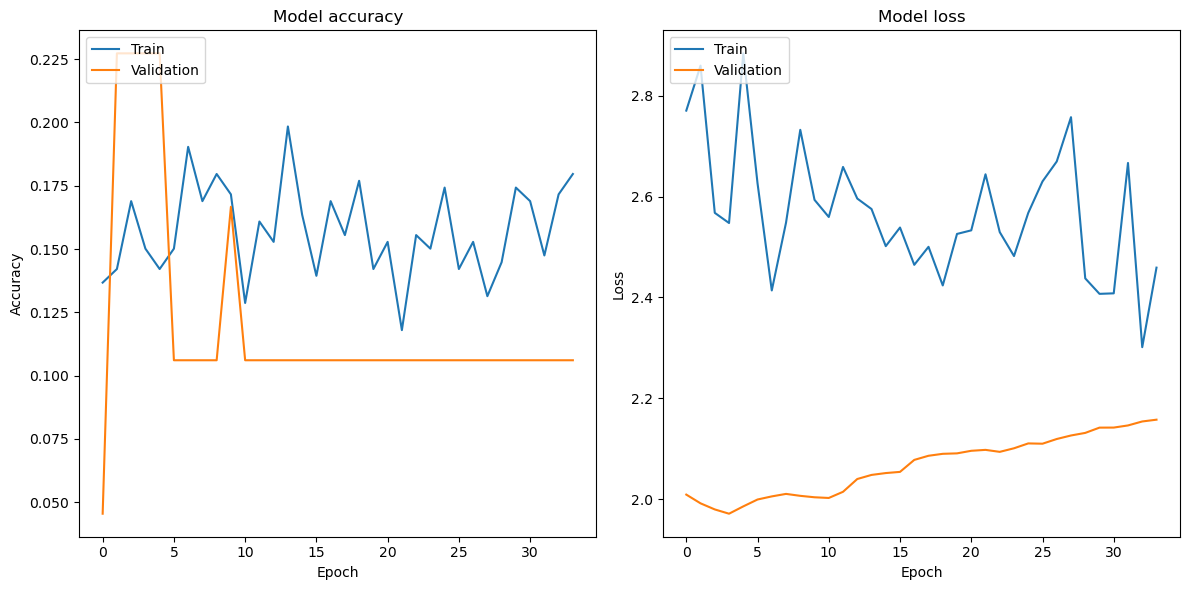

Found 78 validated image filenames belonging to 6 classes.
3/3 [==============================] - 2s 589ms/step - loss: 1.9686 - accuracy: 0.2308


2025-01-15 07:38:43,650 - INFO - Test Loss: 1.9686
2025-01-15 07:38:43,650 - INFO - Test Accuracy: 0.2308


3/3 [==============================] - 3s 578ms/step


2025-01-15 07:38:47,226 - INFO - Classification Report:
                 precision    recall  f1-score   support

        BDC_BDR       0.00      0.00      0.00         8
         Caries       0.23      1.00      0.38        18
Fractured_Teeth       0.00      0.00      0.00         2
  Healthy_Teeth       0.00      0.00      0.00        34
 Impacted_Teeth       0.00      0.00      0.00        13
      Infection       0.00      0.00      0.00         3

       accuracy                           0.23        78
      macro avg       0.04      0.17      0.06        78
   weighted avg       0.05      0.23      0.09        78

2025-01-15 07:38:47,228 - INFO - Classification model evaluation complete.


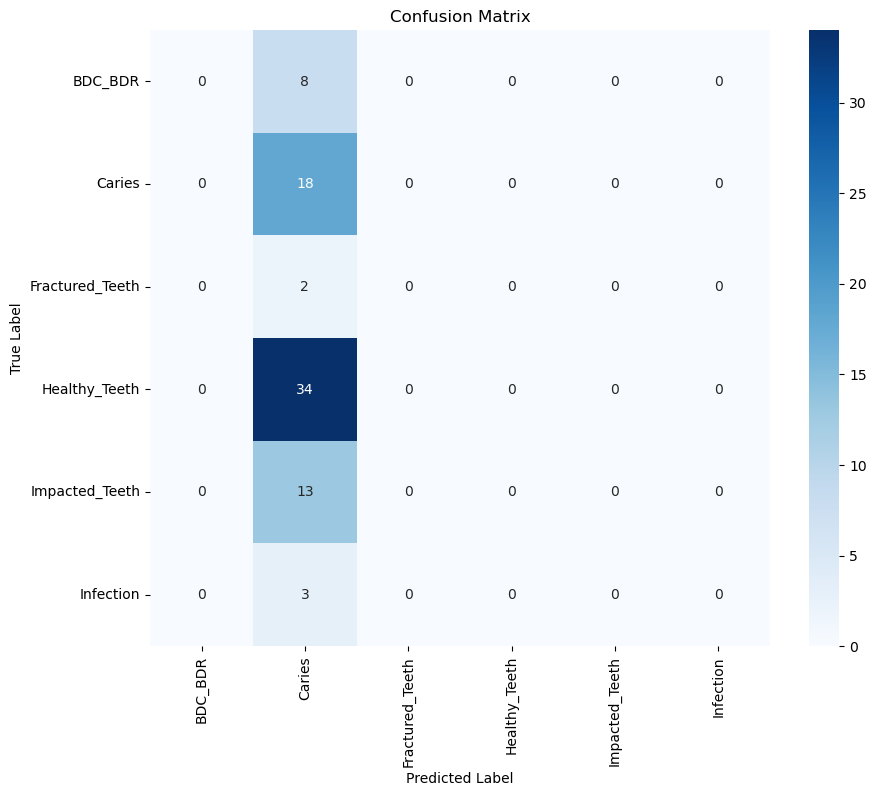

In [13]:
import os
import shutil
import random
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import yaml
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import logging
from PIL import Image
from tqdm import tqdm
import json
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------

DATASET_S3_PATH = "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Dentex_Challenge_Project_Image_Dataset/Ground_Truth/"
LOCAL_DATASET_PATH = "dental_dataset"
CLASS_NAMES = {
    "BDC_BDR": 0,
    "Caries": 1,
    "Fractured_Teeth": 2,
    "Healthy_Teeth": 3,
    "Impacted_Teeth": 4,
    "Infection": 5,
}
NUM_CLASSES = len(CLASS_NAMES)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Enhanced Configuration for classification model
bucket_name = "sagemaker-studio-010526272250-hsf94lgtf6i"
dataset_prefix = "Dentex_Challenge_Project_Image_Dataset/Ground_Truth"
disease_classes = list(CLASS_NAMES.keys())
img_height = 256  # Reduced image size for efficiency
img_width = 256
batch_size = 32  # Batch size
epochs_classification = 120  # Increased epochs
initial_learning_rate = 1e-4  # Reduced learning rate
test_size = 0.15
validation_size = 0.15
seed = 42
local_dataset_dir = 'local_dataset'
dropout_rate = 0.4  # Moderate Dropout
yolo_model_path = 'yolov8n.pt'
cropped_images_path = 'cropped_teeth'
checkpoint_dir = os.path.join(local_dataset_dir, "backup")
patience_early_stopping = 30  # Increased patience
reduce_lr_factor = 0.2  # Reduced LR factor
patience_reduce_lr = 15  # Increased Patience
l2_regularization = 0.0002  # Add L2 Regularization

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('dental_classification.log'),
        logging.StreamHandler()
    ]
)

# -------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------

def download_dataset_from_s3(s3_path, local_path):
    """Downloads dataset from S3 bucket to a local directory."""
    if os.path.exists(local_path):
        logging.info("Dataset already downloaded.")
        return
    logging.info("Downloading dataset from S3...")
    s3 = boto3.resource("s3")
    bucket_name = s3_path.split("/")[2]
    prefix = "/".join(s3_path.split("/")[3:])
    bucket = s3.Bucket(bucket_name)
    
    # List all objects within the prefix to provide a progress bar
    objects_to_download = list(bucket.objects.filter(Prefix=prefix))
    total_objects = len(objects_to_download)
    
    with tqdm(total=total_objects, desc="Downloading Images from S3") as pbar:
        for obj in objects_to_download:
            if not obj.key.endswith("/"):
                local_file_path = os.path.join(local_path, obj.key[len(prefix):].lstrip("/"))
                os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
                bucket.download_file(obj.key, local_file_path)
                pbar.update(1)  # Update progress bar
    
    logging.info("Dataset downloaded.")


def prepare_dataset_for_yolo(local_path):
    """Processes the dataset, splits it, and creates necessary files."""
    image_dir = os.path.join(local_path)
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    annotations = []

    with tqdm(total=len(image_files), desc="Preparing Annotations") as pbar:
        for image_file in image_files:
            label_str = image_file.split("_")[0].replace("-", "_")  # Normalize label
            if label_str in CLASS_NAMES:
                label = CLASS_NAMES[label_str]
                annotations.append((image_file, label))
            else:
                logging.warning(f"Skipping {image_file}, label '{label_str}' not found in class names.")
            pbar.update(1)
    
    random.shuffle(annotations)  # Shuffle before splitting
    train_size = int(TRAIN_RATIO * len(annotations))
    val_size = int(VAL_RATIO * len(annotations))

    train_set = annotations[:train_size]
    val_set = annotations[train_size: train_size + val_size]
    test_set = annotations[train_size + val_size:]

    return train_set, val_set, test_set

def create_yolo_dataset_folders(local_path, train_set, val_set):
    """Creates train and val folders and moves files in those."""
    train_dir = os.path.join(local_path, "train")
    val_dir = os.path.join(local_path, "val")

    train_labels_dir = os.path.join(train_dir, "labels")
    val_labels_dir = os.path.join(val_dir, "labels")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    with tqdm(total=len(train_set), desc="Copying Training Files") as pbar:
        for image_file, label in train_set:
            source_path = os.path.join(local_path, image_file)
            destination_path = os.path.join(train_dir, image_file)
            shutil.copy2(source_path, destination_path)

            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(train_labels_dir, label_file)
            with open(label_path, 'w') as f:
                f.write(f"{label} 0.5 0.5 1 1\n")
            pbar.update(1)
    
    with tqdm(total=len(val_set), desc="Copying Validation Files") as pbar:
        for image_file, label in val_set:
            source_path = os.path.join(local_path, image_file)
            destination_path = os.path.join(val_dir, image_file)
            shutil.copy2(source_path, destination_path)

            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(val_labels_dir, label_file)
            with open(label_path, 'w') as f:
                f.write(f"{label} 0.5 0.5 1 1\n")
            pbar.update(1)


    return train_dir, val_dir

def create_yolo_yaml(local_path, train_dir, val_dir, class_names):
    """Generates a YOLO-compatible YAML file for the dataset."""
    abs_local_path = os.path.abspath(local_path)
    yaml_data = {
        "path": abs_local_path,
        "train": "train",
        "val": "val",
        "nc": len(class_names),
        "names": list(class_names.keys()),
    }
    with open("data.yaml", "w") as file:
        yaml.dump(yaml_data, file, default_flow_style=False)


def prepare_data(bucket_name, dataset_prefix, local_dataset_dir):
    """Prepare and split the data."""
    logging.info("Preparing data...")
    try:
        s3 = boto3.client('s3')
        
        # list all images files
        paginator = s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=dataset_prefix)
        image_paths = []
        for page in pages:
            if 'Contents' in page:
                for obj in page['Contents']:
                    if obj['Key'].lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(obj['Key'])
                        
        if not image_paths:
            raise ValueError("No images found in the specified S3 path.")
        
        # Extract labels from image file names
        labels = [CLASS_NAMES.get(os.path.basename(path).split('_')[0].replace('-', '_'), -1) for path in image_paths]
        
        #Filter out image paths where no label found
        image_paths, labels = zip(*[(path, label) for path, label in zip(image_paths, labels) if label != -1])
        image_paths, labels = list(image_paths), list(labels)

        train_dir = os.path.join(local_dataset_dir, 'train')
        test_dir = os.path.join(local_dataset_dir, 'test')
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        
        def download_images(paths, directory, desc):
            local_paths = []
            with tqdm(total=len(paths), desc=desc) as pbar:
                for img_path in paths:
                    local_path = os.path.join(directory, img_path.split('/')[-1])
                    s3.download_file(bucket_name, img_path, local_path)
                    local_paths.append(local_path)
                    pbar.update(1)
            return local_paths

        train_paths, test_paths, train_labels, test_labels = train_test_split(
            image_paths, labels, test_size=test_size, random_state=seed, stratify=labels
        )
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_paths, train_labels, test_size=validation_size, random_state=seed, stratify=train_labels
        )

        local_train_paths = download_images(train_paths, train_dir, "Downloading training images")
        local_test_paths = download_images(test_paths, test_dir, "Downloading test images")
        local_val_paths = download_images(val_paths, train_dir, "Downloading validation images")
        
        return local_train_paths, train_labels, local_val_paths, val_labels, local_test_paths, test_labels
    except Exception as e:
        logging.error(f"Error preparing data: {e}")
        raise


def build_classification_model(img_height, img_width, num_classes, dropout_rate, l2_regularization):
    """Builds a CNN model for classification with L2 regularization and increased complexity."""
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )
    
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),  # Added Batch Normalization
        layers.Dropout(dropout_rate),
        layers.Dense(
            512, 
            activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)  # Add L2 regularization
        ),
         layers.BatchNormalization(),
        layers.Dropout(dropout_rate / 2), # Reduced dropout for second layer
        layers.Dense(
            256, 
            activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)  # Add L2 regularization
        ),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate / 2), # Reduced dropout for second layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


def calculate_class_weights(labels):
    """Calculates class weights to handle imbalanced data."""
    class_labels = np.unique(labels)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=labels)
    return dict(zip(class_labels, class_weights))


def train_classification_model(model, train_paths, train_labels, val_paths, val_labels, img_height, img_width, batch_size, epochs, initial_learning_rate, local_dataset_dir):
    """Trains the CNN classification model."""
    
    # Convert integer labels to string labels
    train_labels_str = [list(CLASS_NAMES.keys())[label] for label in train_labels]
    val_labels_str = [list(CLASS_NAMES.keys())[label] for label in val_labels]
    
    # Calculate class weights
    class_weights = calculate_class_weights(train_labels)


    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
         brightness_range=[0.8, 1.2],
        
        
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_paths, 'label': train_labels_str}),
        x_col='filename',
        y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        seed=seed,
        shuffle=True
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_paths, 'label': val_labels_str}),
        x_col='filename',
        y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        seed=seed,
        shuffle=False
    )
    
    optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    checkpoint_filepath = os.path.join(local_dataset_dir, 'classification_model_checkpoint.h5')
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=patience_early_stopping, restore_best_weights=True)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_factor, patience=patience_reduce_lr, min_lr=1e-6)
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback],
        class_weight=class_weights
    )
    
    return history
    
def evaluate_classification_model(model, test_paths, test_labels, img_height, img_width, batch_size):
    """Evaluates the trained classification model."""
    # Convert integer labels to string labels
    test_labels_str = [list(CLASS_NAMES.keys())[label] for label in test_labels]
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': test_paths, 'label': test_labels_str}),
        x_col='filename',
        y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )
    
    loss, accuracy = model.evaluate(test_generator, verbose=1)
    logging.info(f'Test Loss: {loss:.4f}')
    logging.info(f'Test Accuracy: {accuracy:.4f}')

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.labels
    
    class_names = list(CLASS_NAMES.keys())
    report = classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0)
    logging.info("Classification Report:\n" + report)

    cm = confusion_matrix(true_labels, predicted_labels)
    return cm, true_labels, predicted_labels


def plot_confusion_matrix(cm, class_names, true_labels, predicted_labels):
    """Plots the confusion matrix."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def plot_history(history):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# Main Execution
# -------------------------------------------------------------
if __name__ == "__main__":
    try:
        download_dataset_from_s3(DATASET_S3_PATH, LOCAL_DATASET_PATH)
        train_data, val_data, test_data = prepare_dataset_for_yolo(LOCAL_DATASET_PATH)
        train_dir, val_dir = create_yolo_dataset_folders(LOCAL_DATASET_PATH, train_data, val_data)
        create_yolo_yaml(LOCAL_DATASET_PATH, train_dir, val_dir, CLASS_NAMES)
        logging.info("Dataset preparation for YOLO complete.")
        
        # Classification Part
        local_train_paths, train_labels, local_val_paths, val_labels, local_test_paths, test_labels = prepare_data(bucket_name, dataset_prefix, local_dataset_dir)
        logging.info("Data preparation for classification complete.")
        
        model = build_classification_model(img_height, img_width, NUM_CLASSES, dropout_rate, l2_regularization)
        logging.info("Classification model built.")
        
        history = train_classification_model(model, local_train_paths, train_labels, local_val_paths, val_labels, img_height, img_width, batch_size, epochs_classification, initial_learning_rate, local_dataset_dir)
        logging.info("Classification model training complete.")
        
        plot_history(history)

        cm, true_labels, predicted_labels = evaluate_classification_model(model, local_test_paths, test_labels, img_height, img_width, batch_size)
        logging.info("Classification model evaluation complete.")
        plot_confusion_matrix(cm, list(CLASS_NAMES.keys()), true_labels, predicted_labels)

    except Exception as e:
        logging.error(f"Error during execution: {e}")

#Code Version8

2025-01-15 07:48:28,243 - INFO - Dataset already downloaded.
Copying Validation Files: 100%|██████████| 77/77 [00:00<00:00, 2906.60it/s]
2025-01-15 07:48:28,451 - INFO - Dataset preparation for YOLO complete.
2025-01-15 07:48:28,452 - INFO - Preparing data...
2025-01-15 07:49:09,184 - INFO - Data preparation for classification complete.
2025-01-15 07:49:11,421 - INFO - Classification model built.


Found 373 validated image filenames belonging to 6 classes.
Found 66 validated image filenames belonging to 6 classes.
Epoch 1/120
12/12 [==============================] - 19s 1s/step - loss: 2.5936 - accuracy: 0.1689 - val_loss: 1.9034 - val_accuracy: 0.0455 - lr: 3.0000e-04
Epoch 2/120
12/12 [==============================] - 11s 898ms/step - loss: 2.5307 - accuracy: 0.1555 - val_loss: 1.8538 - val_accuracy: 0.0455 - lr: 3.0000e-04
Epoch 3/120
12/12 [==============================] - 11s 900ms/step - loss: 2.3722 - accuracy: 0.1877 - val_loss: 1.8372 - val_accuracy: 0.0455 - lr: 3.0000e-04
Epoch 4/120
12/12 [==============================] - 11s 913ms/step - loss: 2.2964 - accuracy: 0.1796 - val_loss: 1.8104 - val_accuracy: 0.0455 - lr: 3.0000e-04
Epoch 5/120
12/12 [==============================] - 11s 900ms/step - loss: 2.4268 - accuracy: 0.1555 - val_loss: 1.7996 - val_accuracy: 0.0455 - lr: 3.0000e-04
Epoch 6/120
12/12 [==============================] - 12s 976ms/step - loss: 2.2

2025-01-15 07:55:53,191 - INFO - Classification model training complete.


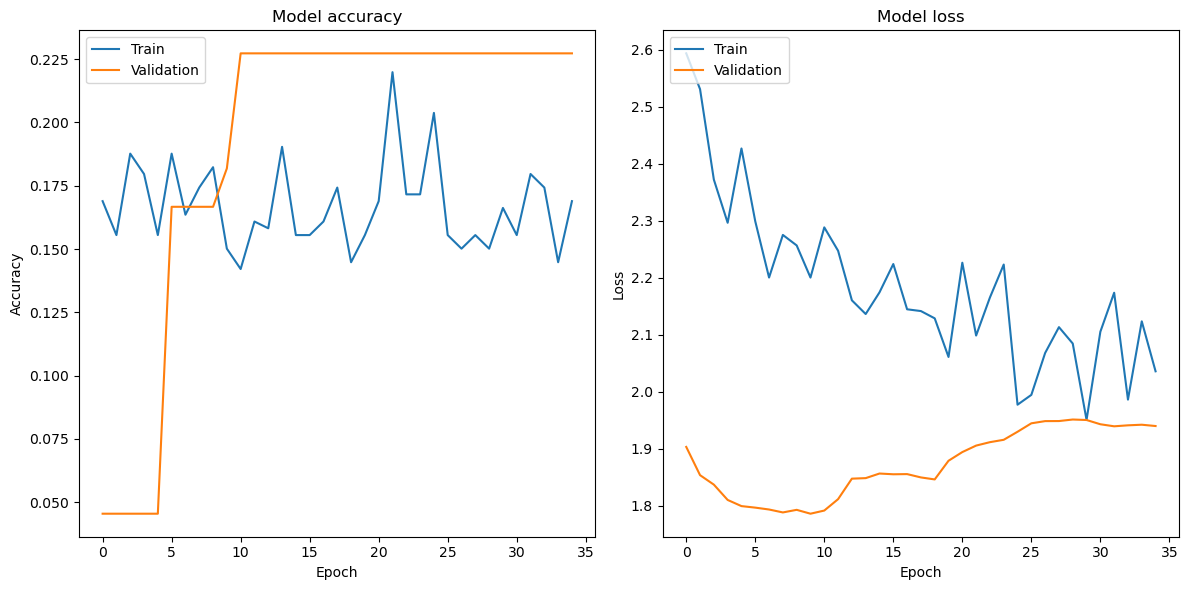

Found 78 validated image filenames belonging to 6 classes.
3/3 [==============================] - 2s 434ms/step - loss: 1.7801 - accuracy: 0.1795


2025-01-15 07:55:55,545 - INFO - Test Loss: 1.7801
2025-01-15 07:55:55,545 - INFO - Test Accuracy: 0.1795


3/3 [==============================] - 3s 406ms/step


2025-01-15 07:55:58,515 - INFO - Classification Report:
                 precision    recall  f1-score   support

        BDC_BDR       0.00      0.00      0.00         8
         Caries       0.14      0.11      0.12        18
Fractured_Teeth       0.00      0.00      0.00         2
  Healthy_Teeth       0.00      0.00      0.00        34
 Impacted_Teeth       0.19      0.92      0.31        13
      Infection       0.00      0.00      0.00         3

       accuracy                           0.18        78
      macro avg       0.06      0.17      0.07        78
   weighted avg       0.06      0.18      0.08        78

2025-01-15 07:55:58,516 - INFO - Classification model evaluation complete.


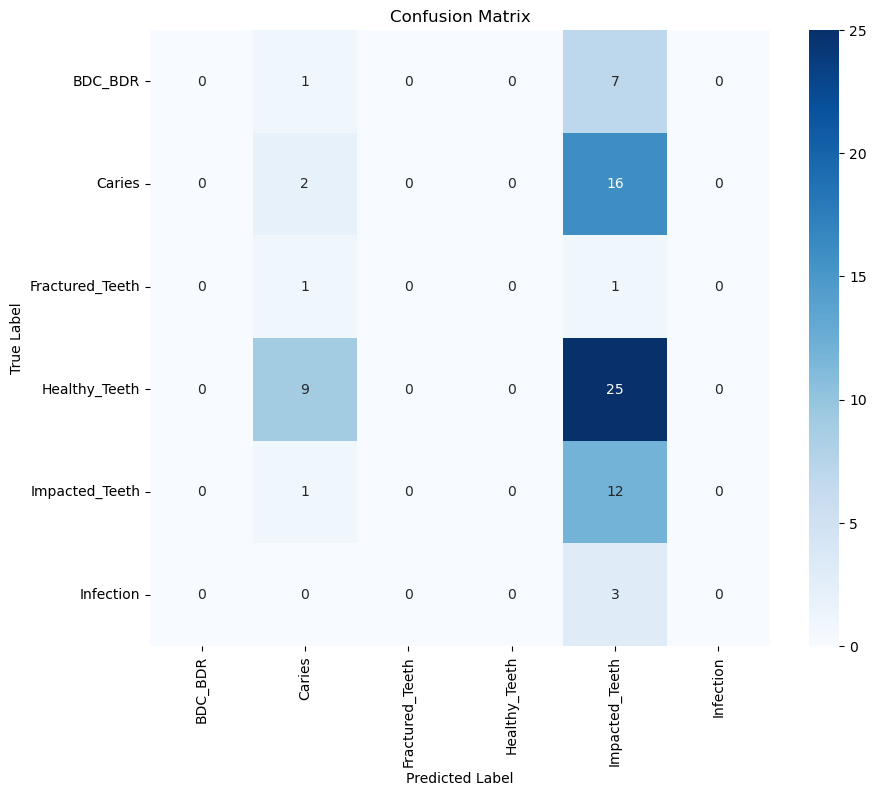

In [15]:
import os
import shutil
import random
import boto3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import yaml
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import logging
from PIL import Image
from tqdm import tqdm
import json
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# -------------------------------------------------------------
# Configuration
# -------------------------------------------------------------

DATASET_S3_PATH = "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Dentex_Challenge_Project_Image_Dataset/Ground_Truth/"
LOCAL_DATASET_PATH = "dental_dataset"
CLASS_NAMES = {
    "BDC_BDR": 0,
    "Caries": 1,
    "Fractured_Teeth": 2,
    "Healthy_Teeth": 3,
    "Impacted_Teeth": 4,
    "Infection": 5,
}
NUM_CLASSES = len(CLASS_NAMES)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Enhanced Configuration for classification model
bucket_name = "sagemaker-studio-010526272250-hsf94lgtf6i"
dataset_prefix = "Dentex_Challenge_Project_Image_Dataset/Ground_Truth"
disease_classes = list(CLASS_NAMES.keys())
img_height = 224  # Reduced image size for efficiency
img_width = 224
batch_size = 32  # Batch size
epochs_classification = 120  # Increased epochs
initial_learning_rate = 3e-4  # Reduced learning rate
test_size = 0.15
validation_size = 0.15
seed = 42
local_dataset_dir = 'local_dataset'
dropout_rate = 0.3  # Moderate Dropout
yolo_model_path = 'yolov8n.pt'
cropped_images_path = 'cropped_teeth'
checkpoint_dir = os.path.join(local_dataset_dir, "backup")
patience_early_stopping = 25  # Increased patience
reduce_lr_factor = 0.3  # Reduced LR factor
patience_reduce_lr = 10  # Increased Patience
l2_regularization = 0.0001  # Add L2 Regularization


# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('dental_classification.log'),
        logging.StreamHandler()
    ]
)

# -------------------------------------------------------------
# Helper Functions
# -------------------------------------------------------------

def download_dataset_from_s3(s3_path, local_path):
    """Downloads dataset from S3 bucket to a local directory."""
    if os.path.exists(local_path):
        logging.info("Dataset already downloaded.")
        return
    logging.info("Downloading dataset from S3...")
    s3 = boto3.resource("s3")
    bucket_name = s3_path.split("/")[2]
    prefix = "/".join(s3_path.split("/")[3:])
    bucket = s3.Bucket(bucket_name)
    
    # List all objects within the prefix to provide a progress bar
    objects_to_download = list(bucket.objects.filter(Prefix=prefix))
    total_objects = len(objects_to_download)
    
    with tqdm(total=total_objects, desc="Downloading Images from S3") as pbar:
        for obj in objects_to_download:
            if not obj.key.endswith("/"):
                local_file_path = os.path.join(local_path, obj.key[len(prefix):].lstrip("/"))
                os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
                bucket.download_file(obj.key, local_file_path)
                pbar.update(1)  # Update progress bar
    
    logging.info("Dataset downloaded.")


def prepare_dataset_for_yolo(local_path):
    """Processes the dataset, splits it, and creates necessary files."""
    image_dir = os.path.join(local_path)
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    annotations = []

    with tqdm(total=len(image_files), desc="Preparing Annotations") as pbar:
        for image_file in image_files:
            label_str = image_file.split("_")[0].replace("-", "_")  # Normalize label
            if label_str in CLASS_NAMES:
                label = CLASS_NAMES[label_str]
                annotations.append((image_file, label))
            else:
                logging.warning(f"Skipping {image_file}, label '{label_str}' not found in class names.")
            pbar.update(1)
    
    random.shuffle(annotations)  # Shuffle before splitting
    train_size = int(TRAIN_RATIO * len(annotations))
    val_size = int(VAL_RATIO * len(annotations))

    train_set = annotations[:train_size]
    val_set = annotations[train_size: train_size + val_size]
    test_set = annotations[train_size + val_size:]

    return train_set, val_set, test_set

def create_yolo_dataset_folders(local_path, train_set, val_set):
    """Creates train and val folders and moves files in those."""
    train_dir = os.path.join(local_path, "train")
    val_dir = os.path.join(local_path, "val")

    train_labels_dir = os.path.join(train_dir, "labels")
    val_labels_dir = os.path.join(val_dir, "labels")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)

    with tqdm(total=len(train_set), desc="Copying Training Files") as pbar:
        for image_file, label in train_set:
            source_path = os.path.join(local_path, image_file)
            destination_path = os.path.join(train_dir, image_file)
            shutil.copy2(source_path, destination_path)

            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(train_labels_dir, label_file)
            with open(label_path, 'w') as f:
                f.write(f"{label} 0.5 0.5 1 1\n")
            pbar.update(1)
    
    with tqdm(total=len(val_set), desc="Copying Validation Files") as pbar:
        for image_file, label in val_set:
            source_path = os.path.join(local_path, image_file)
            destination_path = os.path.join(val_dir, image_file)
            shutil.copy2(source_path, destination_path)

            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(val_labels_dir, label_file)
            with open(label_path, 'w') as f:
                f.write(f"{label} 0.5 0.5 1 1\n")
            pbar.update(1)


    return train_dir, val_dir

def create_yolo_yaml(local_path, train_dir, val_dir, class_names):
    """Generates a YOLO-compatible YAML file for the dataset."""
    abs_local_path = os.path.abspath(local_path)
    yaml_data = {
        "path": abs_local_path,
        "train": "train",
        "val": "val",
        "nc": len(class_names),
        "names": list(class_names.keys()),
    }
    with open("data.yaml", "w") as file:
        yaml.dump(yaml_data, file, default_flow_style=False)


def prepare_data(bucket_name, dataset_prefix, local_dataset_dir):
    """Prepare and split the data."""
    logging.info("Preparing data...")
    try:
        s3 = boto3.client('s3')
        
        # list all images files
        paginator = s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket_name, Prefix=dataset_prefix)
        image_paths = []
        for page in pages:
            if 'Contents' in page:
                for obj in page['Contents']:
                    if obj['Key'].lower().endswith(('.png', '.jpg', '.jpeg')):
                        image_paths.append(obj['Key'])
                        
        if not image_paths:
            raise ValueError("No images found in the specified S3 path.")
        
        # Extract labels from image file names
        labels = [CLASS_NAMES.get(os.path.basename(path).split('_')[0].replace('-', '_'), -1) for path in image_paths]
        
        #Filter out image paths where no label found
        image_paths, labels = zip(*[(path, label) for path, label in zip(image_paths, labels) if label != -1])
        image_paths, labels = list(image_paths), list(labels)

        train_dir = os.path.join(local_dataset_dir, 'train')
        test_dir = os.path.join(local_dataset_dir, 'test')
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)
        
        def download_images(paths, directory, desc):
            local_paths = []
            with tqdm(total=len(paths), desc=desc) as pbar:
                for img_path in paths:
                    local_path = os.path.join(directory, img_path.split('/')[-1])
                    s3.download_file(bucket_name, img_path, local_path)
                    local_paths.append(local_path)
                    pbar.update(1)
            return local_paths

        train_paths, test_paths, train_labels, test_labels = train_test_split(
            image_paths, labels, test_size=test_size, random_state=seed, stratify=labels
        )
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_paths, train_labels, test_size=validation_size, random_state=seed, stratify=train_labels
        )

        local_train_paths = download_images(train_paths, train_dir, "Downloading training images")
        local_test_paths = download_images(test_paths, test_dir, "Downloading test images")
        local_val_paths = download_images(val_paths, train_dir, "Downloading validation images")
        
        return local_train_paths, train_labels, local_val_paths, val_labels, local_test_paths, test_labels
    except Exception as e:
        logging.error(f"Error preparing data: {e}")
        raise


def build_classification_model(img_height, img_width, num_classes, dropout_rate, l2_regularization):
    """Builds a CNN model for classification with L2 regularization and increased complexity."""
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )
    
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),  # Added Batch Normalization
        layers.Dropout(dropout_rate),
        layers.Dense(
            256, 
            activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)  # Add L2 regularization
        ),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate / 2), # Reduced dropout for second layer
        layers.Dense(
            128, 
            activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)  # Add L2 regularization
        ),
        layers.BatchNormalization(),
         layers.Dropout(dropout_rate / 3), # Reduced dropout for second layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


def calculate_class_weights(labels):
    """Calculates class weights to handle imbalanced data."""
    class_labels = np.unique(labels)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=labels)
    return dict(zip(class_labels, class_weights))


def train_classification_model(model, train_paths, train_labels, val_paths, val_labels, img_height, img_width, batch_size, epochs, initial_learning_rate, local_dataset_dir):
    """Trains the CNN classification model."""
    
    # Convert integer labels to string labels
    train_labels_str = [list(CLASS_NAMES.keys())[label] for label in train_labels]
    val_labels_str = [list(CLASS_NAMES.keys())[label] for label in val_labels]
    
    # Calculate class weights
    class_weights = calculate_class_weights(train_labels)


    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
         brightness_range=[0.8, 1.2],
        
        
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_paths, 'label': train_labels_str}),
        x_col='filename',
        y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        seed=seed,
        shuffle=True
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_paths, 'label': val_labels_str}),
        x_col='filename',
        y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        seed=seed,
        shuffle=False
    )
    
    optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    checkpoint_filepath = os.path.join(local_dataset_dir, 'classification_model_checkpoint.keras')
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        save_format='keras'
    )
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=patience_early_stopping, restore_best_weights=True)
    reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_factor, patience=patience_reduce_lr, min_lr=1e-6)
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[model_checkpoint_callback, early_stopping_callback, reduce_lr_callback],
        class_weight=class_weights
    )
    
    return history
    
def evaluate_classification_model(model, test_paths, test_labels, img_height, img_width, batch_size):
    """Evaluates the trained classification model."""
    # Convert integer labels to string labels
    test_labels_str = [list(CLASS_NAMES.keys())[label] for label in test_labels]
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': test_paths, 'label': test_labels_str}),
        x_col='filename',
        y_col='label',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse',
        shuffle=False
    )
    
    loss, accuracy = model.evaluate(test_generator, verbose=1)
    logging.info(f'Test Loss: {loss:.4f}')
    logging.info(f'Test Accuracy: {accuracy:.4f}')

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.labels
    
    class_names = list(CLASS_NAMES.keys())
    report = classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0)
    logging.info("Classification Report:\n" + report)

    cm = confusion_matrix(true_labels, predicted_labels)
    return cm, true_labels, predicted_labels


def plot_confusion_matrix(cm, class_names, true_labels, predicted_labels):
    """Plots the confusion matrix."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def plot_history(history):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# Main Execution
# -------------------------------------------------------------
if __name__ == "__main__":
    try:
        download_dataset_from_s3(DATASET_S3_PATH, LOCAL_DATASET_PATH)
        train_data, val_data, test_data = prepare_dataset_for_yolo(LOCAL_DATASET_PATH)
        train_dir, val_dir = create_yolo_dataset_folders(LOCAL_DATASET_PATH, train_data, val_data)
        create_yolo_yaml(LOCAL_DATASET_PATH, train_dir, val_dir, CLASS_NAMES)
        logging.info("Dataset preparation for YOLO complete.")
        
        # Classification Part
        local_train_paths, train_labels, local_val_paths, val_labels, local_test_paths, test_labels = prepare_data(bucket_name, dataset_prefix, local_dataset_dir)
        logging.info("Data preparation for classification complete.")
        
        model = build_classification_model(img_height, img_width, NUM_CLASSES, dropout_rate, l2_regularization)
        logging.info("Classification model built.")
        
        history = train_classification_model(model, local_train_paths, train_labels, local_val_paths, val_labels, img_height, img_width, batch_size, epochs_classification, initial_learning_rate, local_dataset_dir)
        logging.info("Classification model training complete.")
        
        plot_history(history)

        cm, true_labels, predicted_labels = evaluate_classification_model(model, local_test_paths, test_labels, img_height, img_width, batch_size)
        logging.info("Classification model evaluation complete.")
        plot_confusion_matrix(cm, list(CLASS_NAMES.keys()), true_labels, predicted_labels)

    except Exception as e:
        logging.error(f"Error during execution: {e}")

#Code Version9

2025-01-18 14:57:02,805 - ERROR - Xvfb not found. Please install it for headless operation.
2025-01-18 14:57:02,806 - INFO - Downloading images from S3...
2025-01-18 14:57:39,319 - INFO - Validating images...
Validating images: 100%|██████████| 517/517 [00:00<00:00, 14384.83it/s]
2025-01-18 14:57:39,357 - INFO - Segmenting teeth from images...
Segmenting teeth: 100%|██████████| 517/517 [00:19<00:00, 26.56it/s]
2025-01-18 14:57:58,822 - INFO - Processed 517 images successfully
2025-01-18 14:57:58,822 - INFO - Preparing datasets...
2025-01-18 14:57:58,825 - INFO - Loading train images for SMOTE...
Loading Train Images for SMOTE: 100%|██████████| 330/330 [00:01<00:00, 179.20it/s]
2025-01-18 14:58:00,743 - INFO - Applying SMOTE...
2025-01-18 14:58:12,621 - INFO - Building model...


28456008/28456008 [==============================] - 2s 0us/step


2025-01-18 14:58:18,561 - INFO - Training model...


Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 0.7184 - accuracy: 0.1827 - f1_score_metric: 0.2580
Epoch 1: val_f1_score_metric improved from -inf to 0.00735, saving model to ./logs/20250118-145702/best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 35s 1s/step - loss: 0.7184 - accuracy: 0.1827 - f1_score_metric: 0.2580 - val_loss: 0.3884 - val_accuracy: 0.0625 - val_f1_score_metric: 0.0074
Epoch 2/200
26/26 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.1549 - f1_score_metric: 0.2233
Epoch 2: val_f1_score_metric improved from 0.00735 to 0.11367, saving model to ./logs/20250118-145702/best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 23s 905ms/step - loss: 0.5797 - accuracy: 0.1549 - f1_score_metric: 0.2233 - val_loss: 0.3797 - val_accuracy: 0.2656 - val_f1_score_metric: 0.1137
Epoch 3/200
26/26 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.1549 - f1_score_metric: 0.2229
Epoch 3: val_f1_score_metric did not improve from 0.11367
26/26 [==============================] - 23s 879ms/step - loss: 0.5825 - accuracy: 0.1549 - f1_score_metric: 0.2229 - val_loss: 0.3696 - val_accuracy: 0.2656 - val_f1_score_metric: 0.1137
Epoch 4/200
26/26 [==============================] - ETA: 0s - loss: 0.5616 - accuracy: 0.1463 - f1_score_metric: 0.2108
Epoch 4: val_f1_score_metric did not improve from 0.11367
26/26 [==============================] - 23s 874ms/step - loss: 0.5616 - accuracy: 0.1463 - f1_score_metric: 0.2108 - val_loss: 0.3751 - val_accuracy: 0.2656 - val_f1_score_metric: 0.1137
Epoch 5/200
26/26 [==============================] - ETA: 0s - loss: 0.5441 - 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 23s 897ms/step - loss: 0.4560 - accuracy: 0.1561 - f1_score_metric: 0.2289 - val_loss: 0.3716 - val_accuracy: 0.2344 - val_f1_score_metric: 0.1219
Epoch 20/200
26/26 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.1622 - f1_score_metric: 0.2392
Epoch 20: val_f1_score_metric did not improve from 0.12192
26/26 [==============================] - 23s 878ms/step - loss: 0.4518 - accuracy: 0.1622 - f1_score_metric: 0.2392 - val_loss: 0.3682 - val_accuracy: 0.1719 - val_f1_score_metric: 0.1037
Epoch 21/200
26/26 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.1756 - f1_score_metric: 0.2573
Epoch 21: val_f1_score_metric did not improve from 0.12192
26/26 [==============================] - 23s 891ms/step - loss: 0.4389 - accuracy: 0.1756 - f1_score_metric: 0.2573 - val_loss: 0.3641 - val_accuracy: 0.2656 - val_f1_score_metric: 0.1137
Epoch 22/200
26/26 [==============================] - ETA: 0s - loss: 0.44

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 23s 885ms/step - loss: 0.4360 - accuracy: 0.1732 - f1_score_metric: 0.2480 - val_loss: 0.3595 - val_accuracy: 0.2969 - val_f1_score_metric: 0.1927
Epoch 32/200
26/26 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.1634 - f1_score_metric: 0.2412
Epoch 32: val_f1_score_metric did not improve from 0.19267
26/26 [==============================] - 23s 879ms/step - loss: 0.4234 - accuracy: 0.1634 - f1_score_metric: 0.2412 - val_loss: 0.3614 - val_accuracy: 0.2656 - val_f1_score_metric: 0.1290
Epoch 33/200
26/26 [==============================] - ETA: 0s - loss: 0.4225 - accuracy: 0.1780 - f1_score_metric: 0.2569
Epoch 33: val_f1_score_metric did not improve from 0.19267
26/26 [==============================] - 23s 883ms/step - loss: 0.4225 - accuracy: 0.1780 - f1_score_metric: 0.2569 - val_loss: 0.3826 - val_accuracy: 0.0469 - val_f1_score_metric: 0.0049
Epoch 34/200
26/26 [==============================] - ETA: 0s - loss: 0.42

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 23s 888ms/step - loss: 0.4033 - accuracy: 0.1524 - f1_score_metric: 0.2164 - val_loss: 0.3583 - val_accuracy: 0.3906 - val_f1_score_metric: 0.2808
Epoch 43/200
26/26 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 0.1805 - f1_score_metric: 0.2690
Epoch 43: val_f1_score_metric did not improve from 0.28084
26/26 [==============================] - 23s 879ms/step - loss: 0.4007 - accuracy: 0.1805 - f1_score_metric: 0.2690 - val_loss: 0.3452 - val_accuracy: 0.4375 - val_f1_score_metric: 0.2670
Epoch 44/200
26/26 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.1768 - f1_score_metric: 0.2526
Epoch 44: val_f1_score_metric did not improve from 0.28084
26/26 [==============================] - 23s 884ms/step - loss: 0.3967 - accuracy: 0.1768 - f1_score_metric: 0.2526 - val_loss: 0.3529 - val_accuracy: 0.2812 - val_f1_score_metric: 0.2342
Epoch 45/200
26/26 [==============================] - ETA: 0s - loss: 0.39

2025-01-18 15:25:47,266 - INFO - Evaluating model and generating plots...
Predicting on Test Set: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

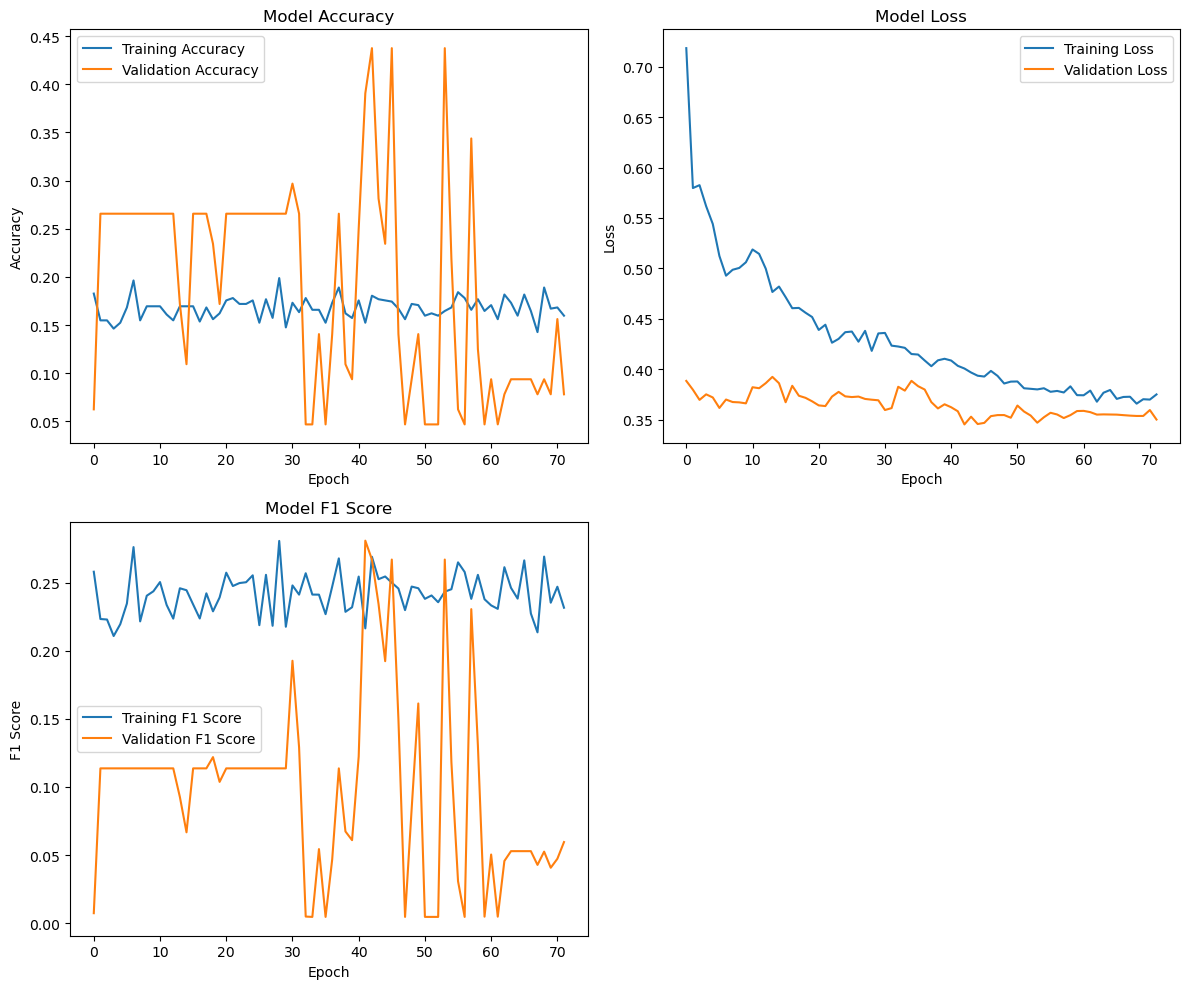

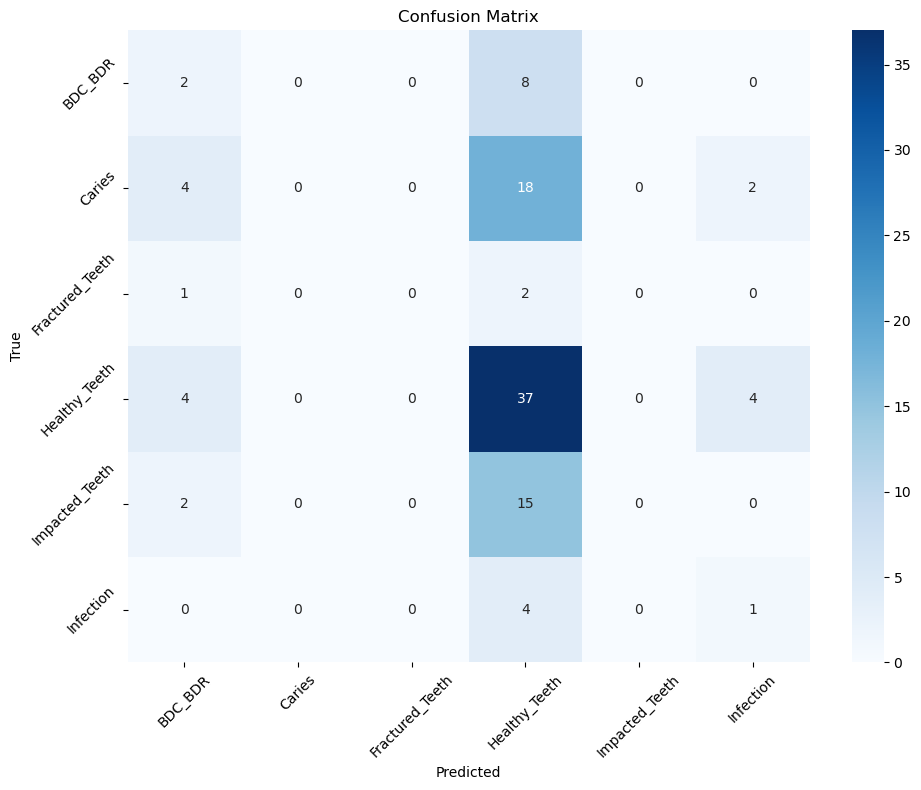

In [14]:
import os
import boto3
import logging
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
import subprocess
from datetime import datetime
from imblearn.over_sampling import SMOTE
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import tensorflow_addons as tfa

# Configuration
S3_BUCKET = "sagemaker-studio-010526272250-hsf94lgtf6i"
S3_PREFIX = "Dentex_Challenge_Project_Image_Dataset/Ground_Truth/"
LOCAL_DIR = "dental_dataset"
CROPPED_DIR = "cropped_teeth"
YOLO_MODEL = "yolov8n.pt"

# Disease classes
CLASSES = {
    "BDC_BDR": 0,
    "Caries": 1,
    "Fractured_Teeth": 2,
    "Healthy_Teeth": 3,
    "Impacted_Teeth": 4,
    "Infection": 5
}

# Model parameters
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 1e-3
MIN_LR = 1e-7
DROPOUT_RATE = 0.4
AUGMENTATION_FACTOR = 4
WEIGHT_DECAY = 1e-4
WARMUP_STEPS = 10
INITIAL_EPOCHS = 10

# Setup logging
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
LOG_DIR = f'./logs/{timestamp}'
os.makedirs(LOG_DIR, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(os.path.join(LOG_DIR, 'training.log')),
        logging.StreamHandler()
    ]
)

def setup_headless_display():
    """Set up headless environment if no display is present."""
    if "DISPLAY" not in os.environ:
        try:
            result = subprocess.run(["which", "Xvfb"], capture_output=True, text=True, check=True)
            xvfb_path = result.stdout.strip()
            if xvfb_path:
                os.system(f"{xvfb_path} :1 -screen 0 1024x768x24 &")
                os.environ["DISPLAY"] = ":1"
        except subprocess.CalledProcessError:
            logging.error("Xvfb not found. Please install it for headless operation.")

def validate_images(image_paths):
    """Validate image files before processing."""
    valid_paths = []
    for path in tqdm(image_paths, desc="Validating images"):
        try:
            with Image.open(path) as img:
                img.verify()
            valid_paths.append(path)
        except Exception as e:
            logging.warning(f"Invalid image file {path}: {e}")
    return valid_paths

def download_from_s3():
    """Download images from S3 bucket."""
    os.makedirs(LOCAL_DIR, exist_ok=True)
    s3 = boto3.client('s3')
    
    paginator = s3.get_paginator('list_objects_v2')
    image_files = []
    
    for page in paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX):
        if 'Contents' in page:
            for obj in page['Contents']:
                if obj['Key'].lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_files.append(obj['Key'])
    
    for file in tqdm(image_files, desc="Downloading images"):
        local_path = os.path.join(LOCAL_DIR, os.path.basename(file))
        s3.download_file(S3_BUCKET, file, local_path)
    
    return [os.path.join(LOCAL_DIR, os.path.basename(f)) for f in image_files]

def segment_teeth(image_paths, use_custom_model=False):
    """Segment teeth using YOLO model or a custom bounding box model."""
    os.makedirs(CROPPED_DIR, exist_ok=True)

    segmented_images = []
    labels = []
    skipped_files = []

    if not use_custom_model:
        try:
            from ultralytics import YOLO
            model = YOLO(YOLO_MODEL)
        except ImportError as e:
            logging.error(f"Error importing ultralytics: {e}")
            raise

    for img_path in tqdm(image_paths, desc="Segmenting teeth"):
        filename = os.path.basename(img_path)
        try:
            disease_label = filename.split('_')[0].replace("-", "_")
            
            matched_label = None
            for valid_label in CLASSES.keys():
                if disease_label.lower() == valid_label.lower():
                    matched_label = valid_label
                    break
            
            if matched_label is None:
                skipped_files.append((filename, disease_label))
                continue
            
            if not use_custom_model:
                results = model.predict(img_path, verbose=False)
            
                if results[0].boxes is not None and len(results[0].boxes) > 0:
                    for idx, box in enumerate(results[0].boxes):
                        try:
                            x1, y1, x2, y2 = map(int, box.xyxy[0])
                            with Image.open(img_path) as image:
                                cropped = image.crop((x1, y1, x2, y2))
                                save_path = os.path.join(CROPPED_DIR, f"{matched_label}_{os.path.splitext(filename)[0]}_{idx}.png")
                                cropped.save(save_path)
                                segmented_images.append(save_path)
                                labels.append(matched_label)
                        except Exception as e:
                            logging.error(f"Error processing crop in {img_path}: {str(e)}")
                else:
                    skipped_files.append((filename, "No bounding boxes detected"))
                    continue
            else:
                with Image.open(img_path) as image:
                    width, height = image.size
                    crop_size = min(width, height) * 0.75
                    x1 = (width - crop_size)/2
                    y1 = (height - crop_size)/2
                    x2 = x1 + crop_size
                    y2 = y1 + crop_size
                    cropped = image.crop((x1, y1, x2, y2))
                    save_path = os.path.join(CROPPED_DIR, f"{matched_label}_{os.path.splitext(filename)[0]}.png")
                    cropped.save(save_path)
                    segmented_images.append(save_path)
                    labels.append(matched_label)
            
        except Exception as e:
            logging.error(f"Error processing {img_path}: {str(e)}")
            skipped_files.append((filename, str(e)))
    
    if skipped_files:
        logging.warning(f"Skipped {len(skipped_files)} files")
        
    logging.info(f"Processed {len(segmented_images)} images successfully")
    return segmented_images, labels

def create_tf_dataset(paths, labels, augment=False):
    """Create TensorFlow dataset with proper error handling and augmentation."""
    def load_and_process(file_path, label):
        def read_image(path):
            try:
                img_raw = tf.io.read_file(path)
                img = tf.io.decode_jpeg(img_raw, channels=3)
                img = tf.cast(img, tf.float32) / 255.0
                img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
                return img
            except Exception as e:
                logging.warning(f"Error reading image {path}: {e}")
                return tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.float32)
        
        img = read_image(file_path)
        
        if augment:
            # Basic augmentations
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_flip_up_down(img)
            img = tf.image.random_brightness(img, max_delta=0.3)
            img = tf.image.random_contrast(img, lower=0.7, upper=1.3)
            img = tf.image.random_saturation(img, lower=0.7, upper=1.3)
            img = tf.image.random_hue(img, max_delta=0.1)
            
            # Rotation using tensorflow_addons
            img = tfa.image.rotate(img, tf.random.uniform(shape=[], minval=-0.2, maxval=0.2))
            
            # Shear transformation
            shear_factor = tf.random.uniform(shape=[], minval=-0.2, maxval=0.2)
            img = tfa.image.transform(img, [1, shear_factor, 0, 0, 1, 0, 0, 0])
            
            # Scale augmentation using resize
            scale = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
            scaled_size = tf.cast(tf.cast([IMG_SIZE, IMG_SIZE], tf.float32) * scale, tf.int32)
            img = tf.image.resize(img, scaled_size)
            img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE, IMG_SIZE)

        return img, label
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_process, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.cache()
    
    return dataset

def prepare_data(image_paths, labels):
    """Prepare data for training with proper stratification and oversampling."""
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    # Create stratified splits
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    # Split the original image paths before SMOTE
    train_val_idx, test_idx = next(splitter.split(image_paths, labels_encoded))
    X_train_val = [image_paths[i] for i in train_val_idx]
    X_test = [image_paths[i] for i in test_idx]
    y_train_val = labels_encoded[train_val_idx]
    y_test = labels_encoded[test_idx]
    
    # Split train_val into train and validation
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(splitter.split(X_train_val, y_train_val))
    X_train = [X_train_val[i] for i in train_idx]
    X_val = [X_train_val[i] for i in val_idx]
    y_train = y_train_val[train_idx]
    y_val = y_train_val[val_idx]
    
    # Load and preprocess images for SMOTE
    feature_vectors_train = []
    logging.info("Loading train images for SMOTE...")
    for path in tqdm(X_train, desc="Loading Train Images for SMOTE"):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.reshape(img, [-1])
        feature_vectors_train.append(img.numpy())
    feature_vectors_train = np.array(feature_vectors_train)
    
    # Apply SMOTE
    logging.info("Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_resampled_features, y_resampled = smote.fit_resample(feature_vectors_train, y_train)
    
    # Create new image paths list matching resampled data
    X_train_resampled = []
    
    # For each class
    for class_label in np.unique(y_train):
        # Get original samples for this class
        original_indices = np.where(y_train == class_label)[0]
        # Get resampled samples for this class
        resampled_indices = np.where(y_resampled == class_label)[0]
        
        # Add original samples
        for idx in original_indices:
            X_train_resampled.append(X_train[idx])
            
        # For synthetic samples, use the nearest original sample's path
        if len(resampled_indices) > len(original_indices):
            extra_needed = len(resampled_indices) - len(original_indices)
            extra_paths = np.random.choice(
                [X_train[idx] for idx in original_indices],
                size=extra_needed,
                replace=True
            )
            X_train_resampled.extend(extra_paths)
    
    # Convert labels to one-hot encoding
    labels_one_hot_train = to_categorical(y_resampled)
    labels_one_hot_val = to_categorical(y_val)
    labels_one_hot_test = to_categorical(y_test)
    
    return X_train_resampled, labels_one_hot_train, X_val, labels_one_hot_val, X_test, labels_one_hot_test, label_encoder

def build_model():
    """Build the EfficientNet model with dropout and batch norm."""
    base_model = applications.efficientnet_v2.EfficientNetV2B1(
        weights='imagenet', # Changed from 'noisy-student'
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
        layers.BatchNormalization(),
        layers.Dropout(DROPOUT_RATE),
        layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    return model

def f1_score_metric(y_true, y_pred):
    """Calculate F1 score metric using tf.numpy_function."""
    def f1_score_numpy(y_true_np, y_pred_np):
        y_pred_labels = np.argmax(y_pred_np, axis=1)
        y_true_labels = np.argmax(y_true_np, axis=1)
        return f1_score(y_true_labels, y_pred_labels, average='weighted')

    f1 = tf.numpy_function(
        func=f1_score_numpy,
        inp=[y_true, y_pred],
        Tout=tf.float64
    )
    return f1

def train_model(model, train_dataset, val_dataset, X_train, X_val, y_train):
    """Train the model with proper callbacks and monitoring."""
    
    # Calculate class weights
    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weight_dict = dict(enumerate(class_weights))
    
    steps_per_epoch = len(X_train) // BATCH_SIZE
    validation_steps = len(X_val) // BATCH_SIZE
    
    # Learning Rate Schedule
    lr_schedule = CosineDecayRestarts(
        initial_learning_rate=LEARNING_RATE,
        first_decay_steps=steps_per_epoch * INITIAL_EPOCHS,
        t_mul=2.0,
        m_mul=0.75,
        alpha=MIN_LR,
    )

    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=WEIGHT_DECAY)
    
    callbacks = [
        EarlyStopping(
            monitor='val_f1_score_metric',
            patience=30,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        ModelCheckpoint(
            os.path.join(LOG_DIR, 'best_model.h5'),
            save_best_only=True,
            monitor='val_f1_score_metric',
            mode='max',
            verbose=1
        ),
        TensorBoard(log_dir=LOG_DIR, histogram_freq=1)
    ]

    model.compile(
        optimizer=optimizer,
        loss=CategoricalFocalCrossentropy(gamma=2.0),
        metrics=['accuracy', f1_score_metric]
    )

    history = model.fit(
        train_dataset.repeat(),
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=callbacks,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        class_weight=class_weight_dict,
        verbose=1
    )
    
    return history

def plot_results(history, test_dataset, model, label_encoder, X_test, y_test):
    """Plot and save training results and generate classification reports."""
    # Plot training history
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(history.history['f1_score_metric'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score_metric'], label='Validation F1 Score')
    plt.title('Model F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(LOG_DIR, 'training_curves.png'))
    
    # Generate predictions
    y_pred = []
    y_true = []
    
    for images, labels in tqdm(test_dataset, desc="Predicting on Test Set"):
        pred = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(pred, axis=1))
        y_true.extend(np.argmax(labels, axis=1))
    
    # Convert to original labels
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_true_labels = label_encoder.inverse_transform(y_true)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(CLASSES.keys()))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(CLASSES.keys()),
                yticklabels=list(CLASSES.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(LOG_DIR, 'confusion_matrix.png'))
    
    # Generate and save classification report
    report = classification_report(y_true_labels, y_pred_labels)
    with open(os.path.join(LOG_DIR, 'classification_report.txt'), 'w') as f:
        f.write(report)
    
    # Calculate and log additional metrics
    balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
    f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
    
    logging.info(f"Balanced Accuracy: {balanced_acc:.4f}")
    logging.info(f"Weighted F1 Score: {f1:.4f}")
    
    return balanced_acc, f1

def save_model_summary(model):
    """Save model architecture summary to a file."""
    with open(os.path.join(LOG_DIR, 'model_summary.txt'), 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))

def main():
    """Main execution function."""
    try:
        # Setup headless display if needed
        setup_headless_display()
        
        # Download images from S3
        logging.info("Downloading images from S3...")
        image_paths = download_from_s3()
        
        # Validate images
        logging.info("Validating images...")
        valid_paths = validate_images(image_paths)
        
        # Segment teeth
        logging.info("Segmenting teeth from images...")
        segmented_images, labels = segment_teeth(valid_paths, use_custom_model=True)
        
        if not segmented_images:
            raise ValueError("No valid segmented images found")
        
        # Prepare datasets
        logging.info("Preparing datasets...")
        X_train, y_train, X_val, y_val, X_test, y_test, label_encoder = prepare_data(segmented_images, labels)
        
        # Create datasets
        train_dataset = create_tf_dataset(X_train, y_train, augment=True)
        val_dataset = create_tf_dataset(X_val, y_val)
        test_dataset = create_tf_dataset(X_test, y_test)
        
        # Build and train model
        logging.info("Building model...")
        model = build_model()
        save_model_summary(model)
        
        logging.info("Training model...")
        history = train_model(model, train_dataset, val_dataset, X_train, X_val, y_train)
        
        # Evaluate and plot results
        logging.info("Evaluating model and generating plots...")
        balanced_acc, f1 = plot_results(history, test_dataset, model, label_encoder, X_test, y_test)
        
        # Save final model
        model.save(os.path.join(LOG_DIR, 'final_model.h5'))
        
        logging.info("Training completed successfully!")
        logging.info(f"Results saved in: {LOG_DIR}")
        
    except Exception as e:
        logging.error(f"An error occurred during execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()